# EfficientNet-B3 Food Classification - Optimized Training
Train EfficientNet-B3 on splits_new_v2 dataset with:
- Strong augmentation and regularization for maximum val accuracy
- Comprehensive evaluation and metrics
- ONNX export with class names

In [1]:
%matplotlib inline
import os, time, json, csv, random, datetime
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import torch_directml
from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
dml = torch_directml.device()
print("Using device:", dml)

Using device: privateuseone:0


In [2]:
# Paths and hyperparameters - optimized for max val accuracy
root_dir = r"d:\VSC FILES\testtrain\splits_new_v2"
assert os.path.isdir(root_dir), f"Dataset not found: {root_dir}"

model_name = "efficientnet_b3"
use_pretrained = True

# Hyperparams (leave LR/schedule unchanged)
image_size = 252
epochs = 60
batch_size = 16
lr = 0.01                 # copied from train.ipynb regime
weight_decay = 1e-4       # copied
num_workers = 0
print_every = 500
accumulate_steps = 4      # gradient accumulation to increase effective batch
# Disable regularization (augment only)
label_smoothing = 0.0
dropout_p = 0.0
mixup_alpha = 0.0
head_warmup_epochs = 1
# NEW: keep single LR for head/backbone
head_lr = lr
backbone_lr = lr
gap_threshold = 0.5
gap_patience = 3
gap_reduce_factor = 1.0

# Early stopping
patience = 5

run_root = os.path.join(os.path.dirname(root_dir), "runs")
ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
run_dir = os.path.join(run_root, f"efficientnet_b3_baseline-{ts}")
os.makedirs(run_dir, exist_ok=True)
print(f"Run directory: {run_dir}")

Run directory: d:\VSC FILES\testtrain\runs\efficientnet_b3_baseline-20251030-102332


In [3]:
# Dataset and DataLoaders with strong augmentation
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Moderate augmentation
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1)),
])

eval_tfms = transforms.Compose([
    transforms.Resize(image_size + 32),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

class SplitDataset(Dataset):
    def __init__(self, root, split, transform=None, classes=None, class_to_idx=None):
        self.root = root
        self.split = split
        self.transform = transform
        if classes is None or class_to_idx is None:
            classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
            class_to_idx = {c: i for i, c in enumerate(classes)}
        self.classes = classes
        self.class_to_idx = class_to_idx
        samples = []
        for cls in self.classes:
            split_dir = os.path.join(root, cls, split)
            if not os.path.isdir(split_dir):
                continue
            for dp, _, fns in os.walk(split_dir):
                for fn in fns:
                    if fn.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".webp")):
                        samples.append((os.path.join(dp, fn), self.class_to_idx[cls]))
        if not samples:
            raise RuntimeError(f"No images for split='{split}' under {root}")
        self.samples = samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        with Image.open(path) as img:
            img = img.convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

train_ds = SplitDataset(root_dir, 'train', transform=train_tfms)
val_ds = SplitDataset(root_dir, 'val', transform=eval_tfms, classes=train_ds.classes, class_to_idx=train_ds.class_to_idx)
test_ds = SplitDataset(root_dir, 'test', transform=eval_tfms, classes=train_ds.classes, class_to_idx=train_ds.class_to_idx)
num_classes = len(train_ds.classes)
print(f"Classes: {num_classes} | train={len(train_ds)} val={len(val_ds)} test={len(test_ds)}")

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

train_eval_ds = SplitDataset(root_dir, 'train', transform=eval_tfms, classes=train_ds.classes, class_to_idx=train_ds.class_to_idx)
train_eval_loader = DataLoader(train_eval_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Save class names
with open(os.path.join(run_dir, 'class_names.json'), 'w') as f:
    json.dump(train_ds.classes, f, indent=2)
print(f"Saved class names to {os.path.join(run_dir, 'class_names.json')}")

Classes: 124 | train=34720 val=4340 test=4340
Saved class names to d:\VSC FILES\testtrain\runs\efficientnet_b3_baseline-20251030-102332\class_names.json


In [4]:
# Model setup
weights = models.EfficientNet_B3_Weights.DEFAULT if use_pretrained else None
model = models.efficientnet_b3(weights=weights)
in_f = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_p),
    nn.Linear(in_f, num_classes)
)
model = model.to(dml)

criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

# Freeze backbone for warmup
for name, p in model.named_parameters():
    if 'classifier' not in name:
        p.requires_grad = False

# Optimizer: head-only param-group for warmup (use SGD + nesterov to match train.ipynb)
optimizer = optim.SGD(
    [
        {'params': [p for n, p in model.named_parameters() if 'classifier' in n and p.requires_grad], 'lr': head_lr}
    ],
    momentum=0.9,
    weight_decay=weight_decay,
    nesterov=True
)
# Per-epoch scheduler + plateau (val-loss)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
plateau = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params/1e6:.2f}M | Trainable: {trainable_params/1e6:.2f}M")

Total params: 10.89M | Trainable: 0.19M


c:\Users\JP\anaconda3\envs\dml\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
# Metrics and utilities
def topk_accuracy(logits, targets, topk=(1, 5)):
    maxk = max(topk)
    _, pred = logits.topk(maxk, dim=1, largest=True, sorted=True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append((correct_k.item() / targets.size(0)) * 100.0)
    return res

class AvgMeter:
    def __init__(self):
        self.reset()
    def reset(self):
        self.sum = 0.0
        self.n = 0
    @property
    def avg(self):
        return self.sum / max(1, self.n)
    def update(self, val, n=1):
        self.sum += float(val) * n
        self.n += n

def mixup_data(x, y, alpha=0.4):
    if alpha <= 0:
        return x, y, None, 1.0
    lam = float(np.random.beta(alpha, alpha))
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)
    mixed_x = lam * x + (1.0 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

log_csv = os.path.join(run_dir, "metrics_epoch.csv")
log_jsonl = os.path.join(run_dir, "metrics_epoch.jsonl")
history = []

In [6]:
# Training and evaluation functions
def train_one_epoch(epoch):
    model.train()
    loss_m, top1_m, top5_m = AvgMeter(), AvgMeter(), AvgMeter()
    t0 = time.perf_counter()
    n_seen = 0

    # start with zeroed grads for accumulation
    optimizer.zero_grad(set_to_none=True)

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(dml)
        labels = labels.to(dml)

        if mixup_alpha > 0:
            images, y_a, y_b, lam = mixup_data(images, labels, alpha=mixup_alpha)
            y_a = y_a.to(dml)
            y_b = y_b.to(dml)
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)

        # scale loss for accumulation
        (loss / accumulate_steps).backward()

        # step once every accumulate_steps (or on last batch)
        if ((i + 1) % accumulate_steps == 0) or ((i + 1) == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        bsz = labels.size(0)
        n_seen += bsz
        top1, top5 = topk_accuracy(outputs, labels, (1, 5))
        loss_m.update(loss.item(), bsz)
        top1_m.update(top1, bsz)
        top5_m.update(top5, bsz)

        if (i + 1) % print_every == 0 or (i + 1) == len(train_loader):
            dt = time.perf_counter() - t0
            ips = n_seen / max(1e-6, dt)
            print(f"Epoch {epoch:02d} | batch {i+1}/{len(train_loader)} | loss {loss_m.avg:.4f} | top1 {top1_m.avg:.2f}% | top5 {top5_m.avg:.2f}% | {ips:.1f} img/s")
    return {"loss": loss_m.avg, "top1": top1_m.avg, "top5": top5_m.avg}

def evaluate(loader):
    model.eval()
    loss_m, top1_m, top5_m = AvgMeter(), AvgMeter(), AvgMeter()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(dml)
            labels = labels.to(dml)
            outputs = model(images)
            loss = criterion(outputs, labels)
            top1, top5 = topk_accuracy(outputs, labels, (1, 5))
            bsz = labels.size(0)
            loss_m.update(loss.item(), bsz)
            top1_m.update(top1, bsz)
            top5_m.update(top5, bsz)
    return {"loss": loss_m.avg, "top1": top1_m.avg, "top5": top5_m.avg}

def log_epoch(row):
    write_header = not os.path.exists(log_csv)
    with open(log_csv, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(row.keys()))
        if write_header:
            w.writeheader()
        w.writerow(row)
    with open(log_jsonl, "a") as f:
        f.write(json.dumps(row) + "\n")

In [7]:
# Training loop with early stopping
best_acc = 0.0
best_path = os.path.join(run_dir, f"best_{model_name}.pth")
no_improve_count = 0

# gap tracking
gap_count = 0

for epoch in range(1, epochs + 1):
    # Unfreeze after warmup
    if epoch == head_warmup_epochs + 1:
        print(f"\n=== Unfreezing backbone at epoch {epoch} (last-k fine-tune) ===")
        last_k = 4
        for p in model.parameters():
            p.requires_grad = False
        for p in model.classifier.parameters():
            p.requires_grad = True
        if hasattr(model, "features"):
            total_blocks = len(model.features)
            start = max(0, total_blocks - last_k)
            for blk in model.features[start:]:
                for p in blk.parameters():
                    p.requires_grad = True
        # Recreate optimizer with head/backbone param-groups
        optimizer = optim.SGD(
            [
                {'params': [p for n, p in model.named_parameters() if 'classifier' in n and p.requires_grad], 'lr': head_lr},
                {'params': [p for n, p in model.named_parameters() if 'classifier' not in n and p.requires_grad], 'lr': backbone_lr},
            ],
            momentum=0.9,
            weight_decay=weight_decay
        )
        remaining = max(1, epochs - epoch + 1)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=remaining)
        plateau = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
        print("  Optimizer recreated. Trainable params:",
              sum(p.numel() for p in model.parameters() if p.requires_grad))

    t0 = time.perf_counter()
    tr = train_one_epoch(epoch)
    tr_clean = evaluate(train_eval_loader)
    va = evaluate(val_loader)

    # Print current LRs and loss gap
    lrs = [g['lr'] for g in optimizer.param_groups]
    lr_strs = [f"{lr:.1e}" for lr in lrs]
    print("  LRs:", lr_strs)
    gap = va["loss"] - tr["loss"]
    print(f"  val-train loss gap: {gap:.4f}")

    # Step plateau scheduler on val loss and per-epoch scheduler
    plateau.step(va["loss"])
    try:
        scheduler.step()
    except Exception:
        pass
    dt = time.perf_counter() - t0

    row = {
        "epoch": epoch,
        "train_loss": round(tr["loss"], 6),
        "train_top1": round(tr["top1"], 4),
        "train_top5": round(tr["top5"], 4),
        "train_eval_loss": round(tr_clean["loss"], 6),
        "train_eval_top1": round(tr_clean["top1"], 4),
        "train_eval_top5": round(tr_clean["top5"], 4),
        "val_loss": round(va["loss"], 6),
        "val_top1": round(va["top1"], 4),
        "val_top5": round(va["top5"], 4),
        "time_s": round(dt, 3)
    }
    history.append(row)
    log_epoch(row)

    print(f"\nEpoch {epoch:02d}/{epochs} | {dt:.1f}s")
    print(f"  Train(mixup): loss {tr['loss']:.4f} | top1 {tr['top1']:.2f}% | top5 {tr['top5']:.2f}%")
    print(f"  Train(clean): loss {tr_clean['loss']:.4f} | top1 {tr_clean['top1']:.2f}% | top5 {tr_clean['top5']:.2f}%")
    print(f"  Val:          loss {va['loss']:.4f} | top1 {va['top1']:.2f}% | top5 {va['top5']:.2f}%")

    # GAP-based overfitting detection / action
    if gap > gap_threshold:
        gap_count += 1
        print(f"  [WARNING] val-train gap={gap:.3f} > {gap_threshold} (count={gap_count}/{gap_patience})")
        # first detection: reduce LR by factor for all param groups
        if gap_count == 1:
            for g in optimizer.param_groups:
                old = g["lr"]
                g["lr"] = old * gap_reduce_factor
            lr_strs = [f"{g['lr']:.1e}" for g in optimizer.param_groups]
            print(f"  Reduced LR by {gap_reduce_factor}x -> {lr_strs}")
        if gap_count >= gap_patience:
            print(f"\n[Early Stop - gap] Validation loss > train loss by >{gap_threshold} for {gap_patience} epochs. Stopping.")
            break
    else:
        gap_count = 0

    # Save best model
    if va["top1"] > best_acc:
        best_acc = va["top1"]
        no_improve_count = 0
        torch.save({
            "model_name": model_name,
            "model_state": model.state_dict(),
            "classes": train_ds.classes,
            "image_size": image_size,
            "mean": mean,
            "std": std,
            "epoch": epoch,
            "val_top1": va["top1"],
            "val_top5": va["top5"]
        }, best_path)
        print(f"  ✓ Saved new best: {best_path} (val Top-1={best_acc:.2f}%)")
    else:
        no_improve_count += 1
        if no_improve_count >= patience:
            print(f"\n[Early Stop] No improvement for {patience} epochs. Stopping.")
            break

print(f"\n=== Training Complete ===")
print(f"Best val Top-1: {best_acc:.2f}%")
print(f"Best model saved to: {best_path}")

Epoch 01 | batch 500/2170 | loss 4.5651 | top1 12.69% | top5 28.43% | 57.7 img/s
Epoch 01 | batch 1000/2170 | loss 4.2970 | top1 21.92% | top5 43.85% | 57.8 img/s
Epoch 01 | batch 1500/2170 | loss 4.0649 | top1 27.40% | top5 51.62% | 57.6 img/s
Epoch 01 | batch 2000/2170 | loss 3.8692 | top1 31.19% | top5 56.52% | 57.5 img/s
Epoch 01 | batch 2170/2170 | loss 3.8088 | top1 32.23% | top5 57.92% | 57.5 img/s
  LRs: ['1.0e-02']
  val-train loss gap: -0.8697

Epoch 01/60 | 897.5s
  Train(mixup): loss 3.8088 | top1 32.23% | top5 57.92%
  Train(clean): loss 2.8931 | top1 52.19% | top5 80.02%
  Val:          loss 2.9392 | top1 50.74% | top5 78.85%
  ✓ Saved new best: d:\VSC FILES\testtrain\runs\efficientnet_b3_baseline-20251030-102332\best_efficientnet_b3.pth (val Top-1=50.74%)

=== Unfreezing backbone at epoch 2 (last-k fine-tune) ===
  Optimizer recreated. Trainable params: 10084426
Epoch 02 | batch 500/2170 | loss 2.0834 | top1 53.92% | top5 81.88% | 39.2 img/s
Epoch 02 | batch 1000/2170 | 

KeyboardInterrupt: 

Saved training curves to: d:\VSC FILES\testtrain\runs\efficientnet_b3_baseline-20251030-102332\training_curves.png


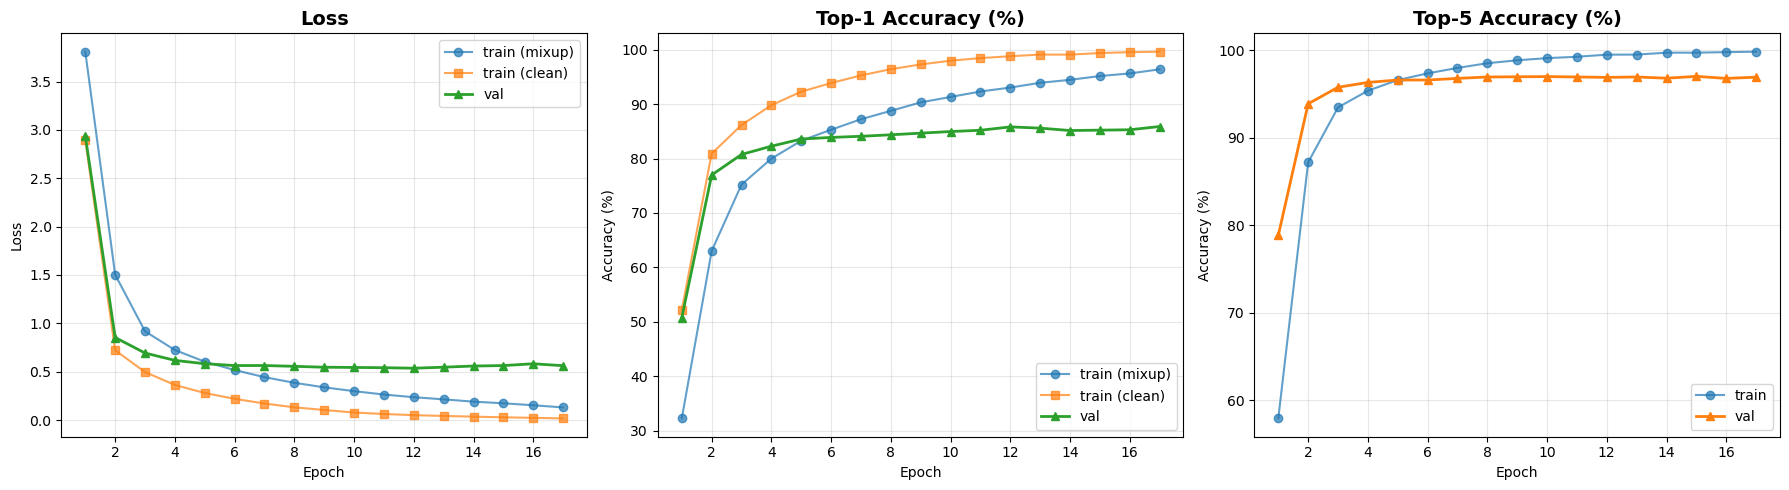

In [8]:
# Plot training curves
epochs_ = [h["epoch"] for h in history]
tr_loss = [h["train_loss"] for h in history]
va_loss = [h["val_loss"] for h in history]
tr_eval_loss = [h["train_eval_loss"] for h in history]
tr_t1 = [h["train_top1"] for h in history]
va_t1 = [h["val_top1"] for h in history]
tr_eval_t1 = [h["train_eval_top1"] for h in history]
tr_t5 = [h["train_top5"] for h in history]
va_t5 = [h["val_top5"] for h in history]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(epochs_, tr_loss, '-o', label='train (mixup)', alpha=0.7)
axes[0].plot(epochs_, tr_eval_loss, '-s', label='train (clean)', alpha=0.7)
axes[0].plot(epochs_, va_loss, '-^', label='val', linewidth=2)
axes[0].set_title('Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Top-1 Accuracy
axes[1].plot(epochs_, tr_t1, '-o', label='train (mixup)', alpha=0.7)
axes[1].plot(epochs_, tr_eval_t1, '-s', label='train (clean)', alpha=0.7)
axes[1].plot(epochs_, va_t1, '-^', label='val', linewidth=2)
axes[1].set_title('Top-1 Accuracy (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Top-5 Accuracy
axes[2].plot(epochs_, tr_t5, '-o', label='train', alpha=0.7)
axes[2].plot(epochs_, va_t5, '-^', label='val', linewidth=2)
axes[2].set_title('Top-5 Accuracy (%)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy (%)')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.savefig(os.path.join(run_dir, "training_curves.png"), dpi=150, bbox_inches='tight')
print(f"Saved training curves to: {os.path.join(run_dir, 'training_curves.png')}")
plt.show()

In [9]:
# Load best model and evaluate on all splits
print("\n=== Loading Best Model ===")
ckpt = torch.load(best_path, map_location="cpu")
classes = ckpt["classes"]

test_model = models.efficientnet_b3(weights=None)
test_model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_p),
    nn.Linear(test_model.classifier[1].in_features, len(classes))
)
test_model.load_state_dict(ckpt["model_state"])
test_model = test_model.to(dml).eval()

print(f"Loaded best model from epoch {ckpt['epoch']}")
print(f"Best val Top-1: {ckpt['val_top1']:.2f}% | Top-5: {ckpt['val_top5']:.2f}%")

def evaluate_detailed(model, loader, split_name):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(dml)
            labels = labels.to(dml)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())
    
    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)
    
    # Top-1 predictions
    top1_probs, top1_preds = all_probs.max(dim=1)
    top1_correct = (top1_preds == all_labels).float()
    top1_acc = top1_correct.mean().item() * 100
    
    # Top-5 predictions
    top5_probs, top5_preds = all_probs.topk(5, dim=1)
    top5_correct = top5_preds.eq(all_labels.view(-1, 1).expand_as(top5_preds))
    top5_acc = top5_correct.any(dim=1).float().mean().item() * 100
    
    # Count samples with top1 confidence >= 80%
    top1_high_conf = (top1_probs >= 0.8).sum().item()
    top1_high_conf_correct = ((top1_probs >= 0.8) & (top1_preds == all_labels)).sum().item()
    
    # Count samples where correct class is in top5 with >= 50% confidence
    correct_in_top5_mask = top5_correct.any(dim=1)
    correct_class_probs = all_probs[torch.arange(len(all_labels)), all_labels]
    top5_high_conf = (correct_in_top5_mask & (correct_class_probs >= 0.5)).sum().item()
    
    # Calculate additional metrics: accuracy, F1, precision, recall
    y_true = all_labels.numpy()
    y_pred = top1_preds.numpy()
    
    accuracy = accuracy_score(y_true, y_pred) * 100
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0) * 100
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    
    print(f"\n{split_name.upper()} Results:")
    print(f"  Total samples: {len(all_labels)}")
    print(f"  Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"  Top-5 Accuracy: {top5_acc:.2f}%")
    print(f"  Accuracy (sklearn): {accuracy:.2f}%")
    print(f"  F1 Score (macro): {f1_macro:.2f}%")
    print(f"  F1 Score (weighted): {f1_weighted:.2f}%")
    print(f"  Precision (macro): {precision_macro:.2f}%")
    print(f"  Precision (weighted): {precision_weighted:.2f}%")
    print(f"  Recall (macro): {recall_macro:.2f}%")
    print(f"  Recall (weighted): {recall_weighted:.2f}%")
    print(f"  Top-1 with ≥80% confidence: {top1_high_conf} ({top1_high_conf/len(all_labels)*100:.2f}%)")
    print(f"    └─ Correct among high-conf: {top1_high_conf_correct} ({top1_high_conf_correct/max(1,top1_high_conf)*100:.2f}%)")
    print(f"  Correct class in Top-5 with ≥50% confidence: {top5_high_conf} ({top5_high_conf/len(all_labels)*100:.2f}%)")
    
    return {
        "split": split_name,
        "total": len(all_labels),
        "top1_acc": top1_acc,
        "top5_acc": top5_acc,
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "top1_conf80_count": top1_high_conf,
        "top1_conf80_correct": top1_high_conf_correct,
        "top5_conf50_count": top5_high_conf,
        "all_probs": all_probs,
        "all_labels": all_labels,
        "all_preds": top1_preds
    }

train_results = evaluate_detailed(test_model, train_eval_loader, "train")
val_results = evaluate_detailed(test_model, val_loader, "val")
test_results = evaluate_detailed(test_model, test_loader, "test")


=== Loading Best Model ===


C:\Users\JP\AppData\Local\Temp\ipykernel_33896\1078135590.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location="cpu")


Loaded best model from epoch 17
Best val Top-1: 85.90% | Top-5: 96.94%

TRAIN Results:
  Total samples: 34720
  Top-1 Accuracy: 99.66%
  Top-5 Accuracy: 99.99%
  Accuracy (sklearn): 99.66%
  F1 Score (macro): 99.66%
  F1 Score (weighted): 99.66%
  Precision (macro): 99.67%
  Precision (weighted): 99.67%
  Recall (macro): 99.66%
  Recall (weighted): 99.66%
  Top-1 with ≥80% confidence: 34210 (98.53%)
    └─ Correct among high-conf: 34195 (99.96%)
  Correct class in Top-5 with ≥50% confidence: 34579 (99.59%)

VAL Results:
  Total samples: 4340
  Top-1 Accuracy: 85.90%
  Top-5 Accuracy: 96.94%
  Accuracy (sklearn): 85.90%
  F1 Score (macro): 85.84%
  F1 Score (weighted): 85.84%
  Precision (macro): 86.31%
  Precision (weighted): 86.31%
  Recall (macro): 85.90%
  Recall (weighted): 85.90%
  Top-1 with ≥80% confidence: 3554 (81.89%)
    └─ Correct among high-conf: 3337 (93.89%)
  Correct class in Top-5 with ≥50% confidence: 3657 (84.26%)

TEST Results:
  Total samples: 4340
  Top-1 Accuracy

In [10]:
# Per-class accuracy analysis
def per_class_accuracy(all_probs, all_labels, classes):
    num_classes = len(classes)
    class_correct = torch.zeros(num_classes)
    class_total = torch.zeros(num_classes)
    
    preds = all_probs.argmax(dim=1)
    for label, pred in zip(all_labels, preds):
        class_total[label] += 1
        if label == pred:
            class_correct[label] += 1
    
    class_acc = (class_correct / class_total.clamp(min=1)) * 100
    
    # Sort by accuracy
    sorted_indices = torch.argsort(class_acc, descending=True)
    
    return class_acc, class_total, sorted_indices

print("\n=== Per-Class Accuracy (Test Set) ===")
class_acc, class_total, sorted_idx = per_class_accuracy(
    test_results["all_probs"],
    test_results["all_labels"],
    classes
)

# Top 10 best classes
print("\nTop 10 Best Classes:")
for i in range(min(10, len(classes))):
    idx = sorted_idx[i]
    print(f"  {i+1}. {classes[idx]}: {class_acc[idx]:.2f}% ({int(class_total[idx])} samples)")

# Bottom 10 worst classes
print("\nBottom 10 Worst Classes:")
for i in range(min(10, len(classes))):
    idx = sorted_idx[-(i+1)]
    print(f"  {i+1}. {classes[idx]}: {class_acc[idx]:.2f}% ({int(class_total[idx])} samples)")

# Save per-class results
per_class_results = []
for i in range(len(classes)):
    per_class_results.append({
        "class": classes[i],
        "accuracy": float(class_acc[i]),
        "total": int(class_total[i])
    })

with open(os.path.join(run_dir, "per_class_accuracy.json"), "w") as f:
    json.dump(per_class_results, f, indent=2)
print(f"\nSaved per-class accuracy to: {os.path.join(run_dir, 'per_class_accuracy.json')}")


=== Per-Class Accuracy (Test Set) ===

Top 10 Best Classes:
  1. apple: 100.00% (35 samples)
  2. sausage: 100.00% (35 samples)
  3. balut: 100.00% (35 samples)
  4. pritong_galunggong: 100.00% (35 samples)
  5. white_rice: 100.00% (35 samples)
  6. leche_flan: 100.00% (35 samples)
  7. isaw_manok: 100.00% (35 samples)
  8. kikiam: 100.00% (35 samples)
  9. tuyo: 100.00% (35 samples)
  10. tempura: 100.00% (35 samples)

Bottom 10 Worst Classes:
  1. pork_bistek: 45.71% (35 samples)
  2. chocolate_cake: 57.14% (35 samples)
  3. pork_chop: 60.00% (35 samples)
  4. grilled_cheese_sandwich: 62.86% (35 samples)
  5. omelette: 62.86% (35 samples)
  6. bread_pudding: 62.86% (35 samples)
  7. cheesecake: 65.71% (35 samples)
  8. beef_sinigang: 65.71% (35 samples)
  9. steak: 68.57% (35 samples)
  10. french_toast: 71.43% (35 samples)

Saved per-class accuracy to: d:\VSC FILES\testtrain\runs\efficientnet_b3_baseline-20251030-102332\per_class_accuracy.json


Saved per-class accuracy chart to: d:\VSC FILES\testtrain\runs\efficientnet_b3_baseline-20251030-102332\per_class_accuracy.png


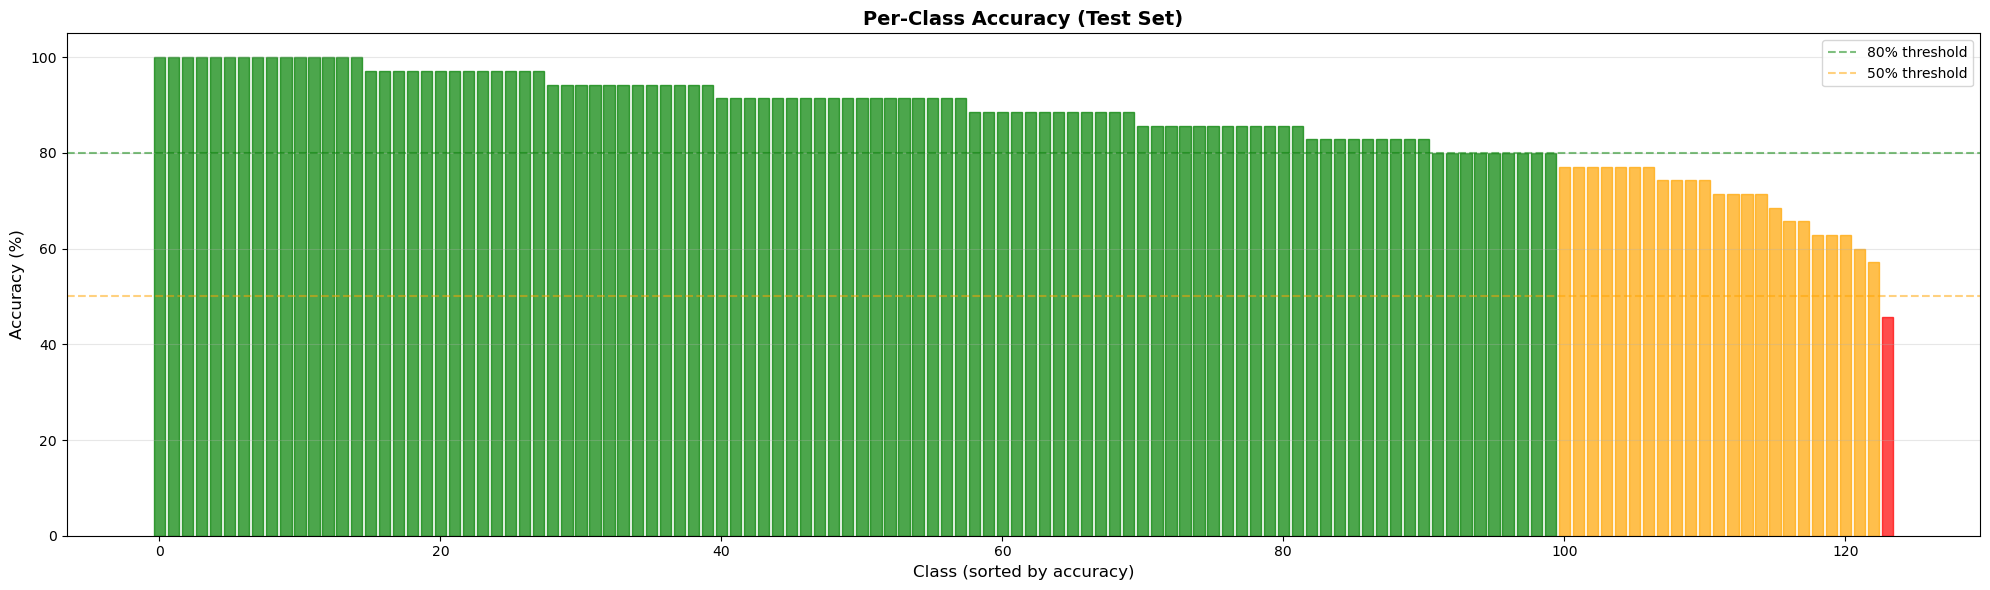

In [11]:
# Visualize per-class accuracy
fig, ax = plt.subplots(figsize=(20, 6))
class_names_sorted = [classes[i] for i in sorted_idx]
acc_sorted = [class_acc[i].item() for i in sorted_idx]

bars = ax.bar(range(len(classes)), acc_sorted, color='steelblue', alpha=0.7)

# Color code: green for >80%, yellow for 50-80%, red for <50%
for i, (bar, acc) in enumerate(zip(bars, acc_sorted)):
    if acc >= 80:
        bar.set_color('green')
    elif acc >= 50:
        bar.set_color('orange')
    else:
        bar.set_color('red')

ax.set_xlabel('Class (sorted by accuracy)', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Per-Class Accuracy (Test Set)', fontsize=14, fontweight='bold')
ax.axhline(y=80, color='green', linestyle='--', alpha=0.5, label='80% threshold')
ax.axhline(y=50, color='orange', linestyle='--', alpha=0.5, label='50% threshold')
ax.grid(axis='y', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(run_dir, "per_class_accuracy.png"), dpi=150, bbox_inches='tight')
print(f"Saved per-class accuracy chart to: {os.path.join(run_dir, 'per_class_accuracy.png')}")
plt.show()


=== Top 10 Most Confused Class Pairs ===
  1. pork_bistek → beef_bistek: 15 times
  2. beef_sinigang → pork_sinigang: 11 times
  3. beef_bistek → pork_bistek: 5 times
  4. pancit_bihon → pancit_canton: 5 times
  5. pork_sinigang → beef_sinigang: 5 times
  6. beef_kaldereta → pork_menudo: 4 times
  7. chicken_afritada → beef_kaldereta: 4 times
  8. chocolate_cake → chocolate_mousse: 4 times
  9. lechon_baboy → lechon_manok: 4 times
  10. pork_chop → steak: 4 times

Saved confusion matrix to: d:\VSC FILES\testtrain\runs\efficientnet_b3_baseline-20251030-102332\confusion_matrix.png


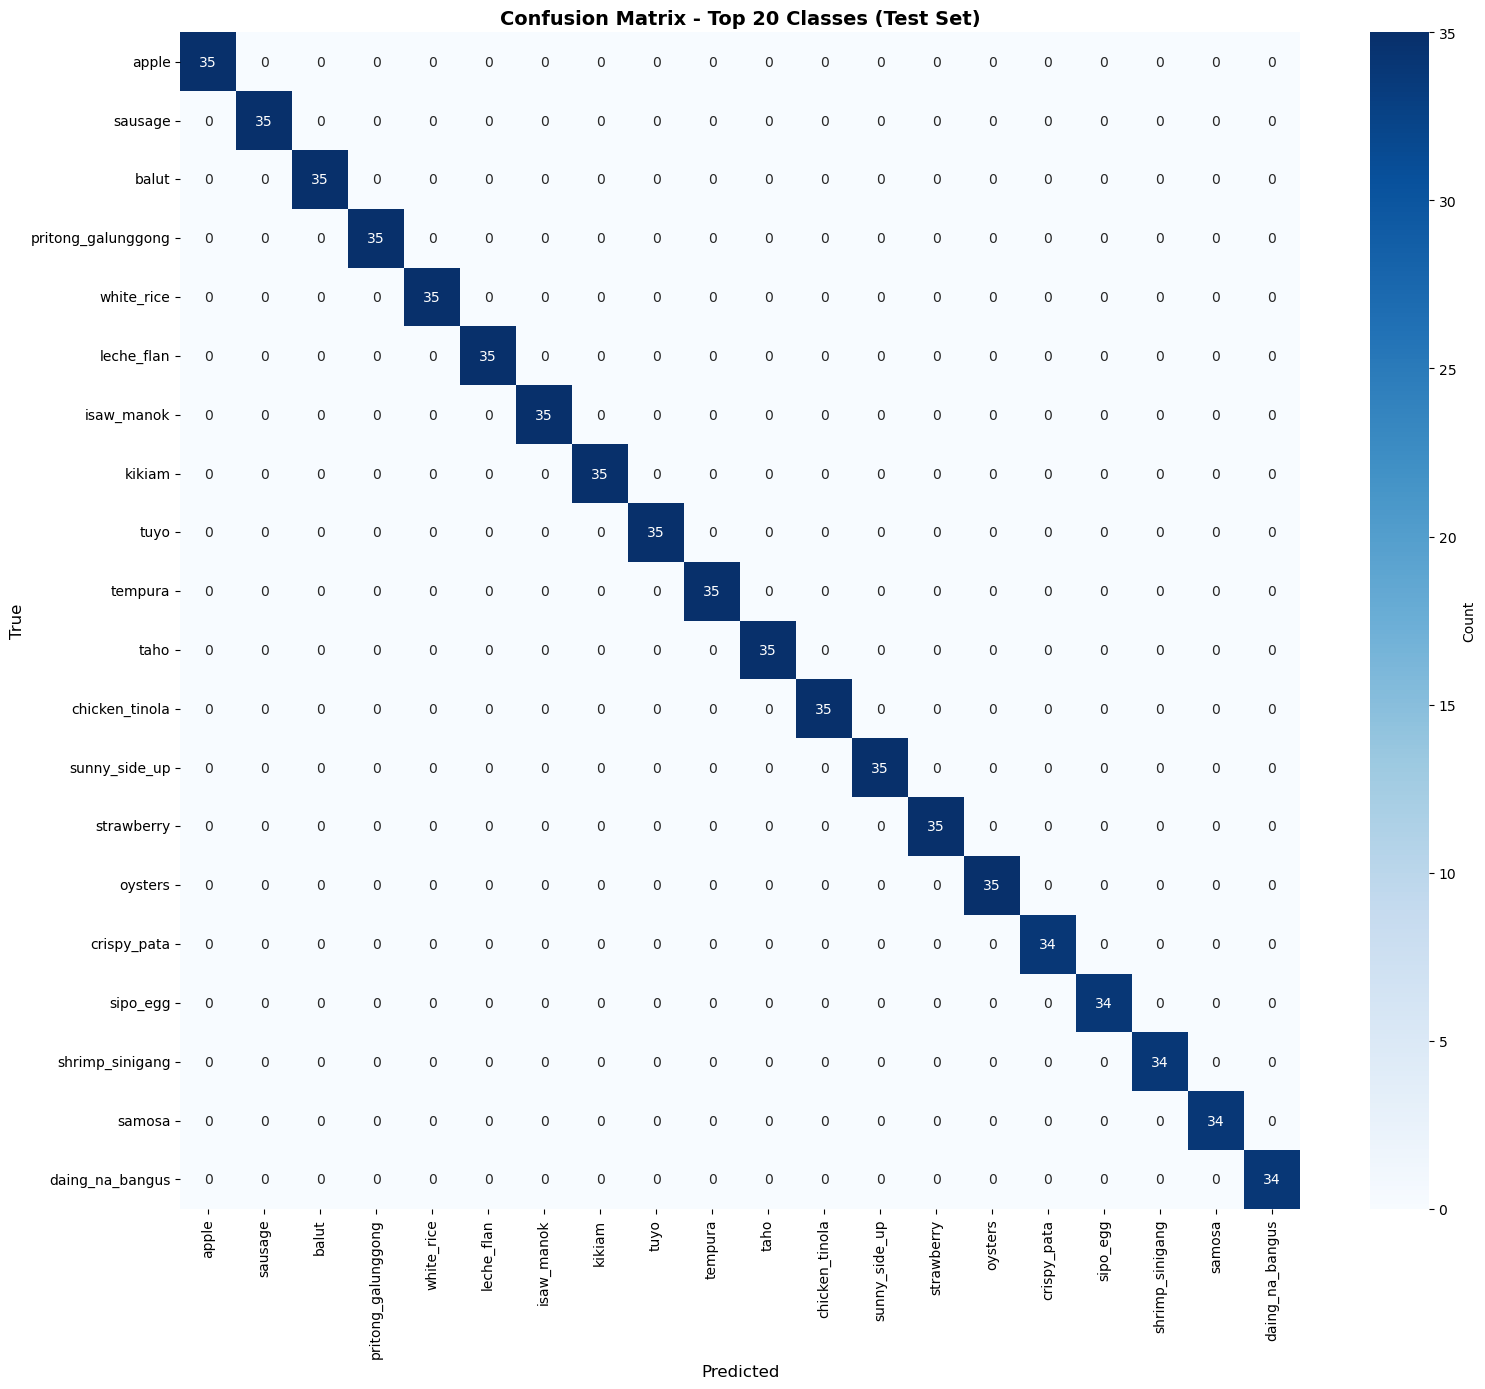

In [12]:
# Confusion matrix for top confusing classes
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
preds = test_results["all_probs"].argmax(dim=1).numpy()
labels = test_results["all_labels"].numpy()

# Full confusion matrix
cm = confusion_matrix(labels, preds)

# Find most confused pairs
confused_pairs = []
for i in range(len(classes)):
    for j in range(len(classes)):
        if i != j and cm[i, j] > 0:
            confused_pairs.append((i, j, cm[i, j]))

confused_pairs.sort(key=lambda x: x[2], reverse=True)

print("\n=== Top 10 Most Confused Class Pairs ===")
for i, (true_idx, pred_idx, count) in enumerate(confused_pairs[:10], 1):
    print(f"  {i}. {classes[true_idx]} → {classes[pred_idx]}: {count} times")

# Plot confusion matrix for top 20 classes
top_n = 20
top_classes_idx = sorted_idx[:top_n].tolist()
cm_subset = cm[np.ix_(top_classes_idx, top_classes_idx)]
class_names_subset = [classes[i] for i in top_classes_idx]

plt.figure(figsize=(16, 14))
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_subset, yticklabels=class_names_subset,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(f'Confusion Matrix - Top {top_n} Classes (Test Set)', fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(run_dir, "confusion_matrix.png"), dpi=150, bbox_inches='tight')
print(f"\nSaved confusion matrix to: {os.path.join(run_dir, 'confusion_matrix.png')}")
plt.show()

In [13]:
# Detailed classification report
print("\n=== Classification Report (Test Set) ===")
y_true = test_results["all_labels"].numpy()
y_pred = test_results["all_preds"].numpy()

# Full classification report
report = classification_report(y_true, y_pred, target_names=classes, digits=4, zero_division=0)
print(report)

# Save classification report
report_path = os.path.join(run_dir, "classification_report.txt")
with open(report_path, "w") as f:
    f.write("Classification Report (Test Set)\n")
    f.write("="*80 + "\n\n")
    f.write(report)
print(f"\nSaved classification report to: {report_path}")

# Generate per-class metrics
report_dict = classification_report(y_true, y_pred, target_names=classes, output_dict=True, zero_division=0)
per_class_metrics = []
for class_name in classes:
    if class_name in report_dict:
        metrics = report_dict[class_name]
        per_class_metrics.append({
            "class": class_name,
            "precision": metrics["precision"] * 100,
            "recall": metrics["recall"] * 100,
            "f1_score": metrics["f1-score"] * 100,
            "support": metrics["support"]
        })

# Save per-class metrics
metrics_path = os.path.join(run_dir, "per_class_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(per_class_metrics, f, indent=2)
print(f"Saved per-class metrics to: {metrics_path}")


=== Classification Report (Test Set) ===
                         precision    recall  f1-score   support

          adobong_pusit     0.9167    0.9429    0.9296        35
                  apple     1.0000    1.0000    1.0000        35
            arroz_caldo     0.9412    0.9143    0.9275        35
         baby_back_ribs     0.8333    0.8571    0.8451        35
           baked_tahong     0.9706    0.9429    0.9565        35
                  balut     0.9459    1.0000    0.9722        35
            beef_bistek     0.6364    0.8000    0.7089        35
         beef_kaldereta     0.7714    0.7714    0.7714        35
          beef_sinigang     0.7667    0.6571    0.7077        35
           beef_tartare     0.7812    0.7143    0.7463        35
               beignets     0.9394    0.8857    0.9118        35
               bibimbap     0.8333    0.8571    0.8451        35
                   biko     0.9167    0.9429    0.9296        35
             boiled_egg     0.9714    0.9714   

In [14]:
# Export to ONNX
print("\n=== Exporting to ONNX ===")

onnx_path = os.path.join(run_dir, "model.onnx")
dummy_input = torch.randn(1, 3, image_size, image_size).to(dml)

test_model.eval()
torch.onnx.export(
    test_model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=14,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print(f"✓ Exported ONNX model to: {onnx_path}")
print(f"  Input shape: [batch_size, 3, {image_size}, {image_size}]")
print(f"  Output shape: [batch_size, {num_classes}]")
print(f"  Class names saved to: {os.path.join(run_dir, 'class_names.json')}")

# Test ONNX model
import onnx
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("✓ ONNX model is valid")


=== Exporting to ONNX ===
✓ Exported ONNX model to: d:\VSC FILES\testtrain\runs\efficientnet_b3_baseline-20251030-102332\model.onnx
  Input shape: [batch_size, 3, 252, 252]
  Output shape: [batch_size, 124]
  Class names saved to: d:\VSC FILES\testtrain\runs\efficientnet_b3_baseline-20251030-102332\class_names.json
✓ ONNX model is valid


In [15]:
# Final summary report
summary = {
    "model": model_name,
    "num_classes": num_classes,
    "image_size": image_size,
    "total_epochs_trained": len(history),
    "best_epoch": ckpt["epoch"],
    "best_val_top1": ckpt["val_top1"],
    "best_val_top5": ckpt["val_top5"],
    "train_results": {
        "total": train_results["total"],
        "top1_acc": train_results["top1_acc"],
        "top5_acc": train_results["top5_acc"],
        "accuracy": train_results["accuracy"],
        "f1_macro": train_results["f1_macro"],
        "f1_weighted": train_results["f1_weighted"],
        "precision_macro": train_results["precision_macro"],
        "precision_weighted": train_results["precision_weighted"],
        "recall_macro": train_results["recall_macro"],
        "recall_weighted": train_results["recall_weighted"],
        "top1_conf80_count": train_results["top1_conf80_count"],
        "top1_conf80_percent": train_results["top1_conf80_count"] / train_results["total"] * 100,
        "top5_conf50_count": train_results["top5_conf50_count"],
        "top5_conf50_percent": train_results["top5_conf50_count"] / train_results["total"] * 100
    },
    "val_results": {
        "total": val_results["total"],
        "top1_acc": val_results["top1_acc"],
        "top5_acc": val_results["top5_acc"],
        "accuracy": val_results["accuracy"],
        "f1_macro": val_results["f1_macro"],
        "f1_weighted": val_results["f1_weighted"],
        "precision_macro": val_results["precision_macro"],
        "precision_weighted": val_results["precision_weighted"],
        "recall_macro": val_results["recall_macro"],
        "recall_weighted": val_results["recall_weighted"],
        "top1_conf80_count": val_results["top1_conf80_count"],
        "top1_conf80_percent": val_results["top1_conf80_count"] / val_results["total"] * 100,
        "top5_conf50_count": val_results["top5_conf50_count"],
        "top5_conf50_percent": val_results["top5_conf50_count"] / val_results["total"] * 100
    },
    "test_results": {
        "total": test_results["total"],
        "top1_acc": test_results["top1_acc"],
        "top5_acc": test_results["top5_acc"],
        "accuracy": test_results["accuracy"],
        "f1_macro": test_results["f1_macro"],
        "f1_weighted": test_results["f1_weighted"],
        "precision_macro": test_results["precision_macro"],
        "precision_weighted": test_results["precision_weighted"],
        "recall_macro": test_results["recall_macro"],
        "recall_weighted": test_results["recall_weighted"],
        "top1_conf80_count": test_results["top1_conf80_count"],
        "top1_conf80_percent": test_results["top1_conf80_count"] / test_results["total"] * 100,
        "top5_conf50_count": test_results["top5_conf50_count"],
        "top5_conf50_percent": test_results["top5_conf50_count"] / test_results["total"] * 100
    },
    "files": {
        "best_model": best_path,
        "onnx_model": onnx_path,
        "class_names": os.path.join(run_dir, "class_names.json"),
        "training_curves": os.path.join(run_dir, "training_curves.png"),
        "per_class_accuracy": os.path.join(run_dir, "per_class_accuracy.json"),
        "per_class_metrics": os.path.join(run_dir, "per_class_metrics.json"),
        "classification_report": os.path.join(run_dir, "classification_report.txt"),
        "confusion_matrix": os.path.join(run_dir, "confusion_matrix.png"),
    }
}

summary_path = os.path.join(run_dir, "summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Model: {model_name}")
print(f"Classes: {num_classes}")
print(f"Image size: {image_size}x{image_size}")
print(f"Epochs trained: {len(history)}")
print(f"Best epoch: {ckpt['epoch']}")
print(f"\nBest Validation Accuracy:")
print(f"  Top-1: {ckpt['val_top1']:.2f}%")
print(f"  Top-5: {ckpt['val_top5']:.2f}%")
print(f"\nTest Set Results:")
print(f"  Top-1 Accuracy: {test_results['top1_acc']:.2f}%")
print(f"  Top-5 Accuracy: {test_results['top5_acc']:.2f}%")
print(f"  Accuracy: {test_results['accuracy']:.2f}%")
print(f"  F1 Score (macro): {test_results['f1_macro']:.2f}%")
print(f"  F1 Score (weighted): {test_results['f1_weighted']:.2f}%")
print(f"  Precision (macro): {test_results['precision_macro']:.2f}%")
print(f"  Precision (weighted): {test_results['precision_weighted']:.2f}%")
print(f"  Recall (macro): {test_results['recall_macro']:.2f}%")
print(f"  Recall (weighted): {test_results['recall_weighted']:.2f}%")
print(f"  Top-1 predictions with ≥80% confidence: {test_results['top1_conf80_count']} ({test_results['top1_conf80_count']/test_results['total']*100:.2f}%)")
print(f"  Correct class in Top-5 with ≥50% confidence: {test_results['top5_conf50_count']} ({test_results['top5_conf50_count']/test_results['total']*100:.2f}%)")
print(f"\nOutput files saved to: {run_dir}")
print(f"  - Best model (PyTorch): {os.path.basename(best_path)}")
print(f"  - ONNX model: model.onnx")
print(f"  - Class names: class_names.json")
print(f"  - Per-class metrics: per_class_metrics.json")
print(f"  - Classification report: classification_report.txt")
print(f"  - Summary: summary.json")
print("="*60)


FINAL SUMMARY
Model: efficientnet_b3
Classes: 124
Image size: 252x252
Epochs trained: 17
Best epoch: 17

Best Validation Accuracy:
  Top-1: 85.90%
  Top-5: 96.94%

Test Set Results:
  Top-1 Accuracy: 86.87%
  Top-5 Accuracy: 97.30%
  Accuracy: 86.87%
  F1 Score (macro): 86.76%
  F1 Score (weighted): 86.76%
  Precision (macro): 87.09%
  Precision (weighted): 87.09%
  Recall (macro): 86.87%
  Recall (weighted): 86.87%
  Top-1 predictions with ≥80% confidence: 3581 (82.51%)
  Correct class in Top-5 with ≥50% confidence: 3692 (85.07%)

Output files saved to: d:\VSC FILES\testtrain\runs\efficientnet_b3_baseline-20251030-102332
  - Best model (PyTorch): best_efficientnet_b3.pth
  - ONNX model: model.onnx
  - Class names: class_names.json
  - Per-class metrics: per_class_metrics.json
  - Classification report: classification_report.txt
  - Summary: summary.json
